In [1]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from livelossplot import PlotLossesKerasTF
tf.random.set_seed(1234)

import datasets
import losses
import cnns
from models import Model

from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr
import pickle
import matplotlib.pyplot as plt
from sklearn import linear_model

from matplotlib.colors import Normalize
import matplotlib.cm as cm
import matplotlib.colors as colors
import pandas as pd
from statsmodels.miscmodels.ordinal_model import OrderedModel
import matplotlib
matplotlib.rcParams.update({'font.size': 13})

import cv2
from scipy.special import softmax

Using TensorFlow backend


c:\Users\ugail\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\ugail\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.11.0 and strictly below 2.14.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.1 and is not supported. 
Some things might work, some things might not.
If you were to encoun

In [2]:
names = np.array([
    "mediapipe",
    "nose",
    "lips",
    "eyes",
    "left_eye",
    "right_eye",
    "cheeks",
    "left_cheek",
    "right_cheek",
    "chin",
    "eyebrows",
    "left_eyebrow",
    "right_eyebrow",
])

names2 = np.array([
    "full face",
    "nose",
    "lips",
    "eyes",
    "left eye",
    "right eye",
    "cheeks",
    "left cheek",
    "right cheek",
    "chin",
    "eyebrows",
    "left eyebrow",
    "right eyebrow",
])

names3 = np.array([
    "mediapipe",
    "nose",
    "lips",
    "eyes",
    "cheeks",
    "chin",
    "eyebrows",
])

names4 = np.array([
    "full face",
    "nose",
    "lips",
    "eyes",
    "cheeks",
    "chin",
    "eyebrows",
])

In [3]:
def load_y(path, output_size):
    with open(path, "r") as f:
        lines = f.readlines()
        
    if output_size == 5:
        y = np.array([l.split(" ")[1:6] for l in lines], np.float32)
        
    elif output_size == 10:
        y = np.array([l.split(" ")[1:11] for l in lines], np.float32)

    return y

In [10]:
def SFP(dataset, combined=False, percentage=True, train=False):
    n = 1
    if dataset == "SCUT-FBP5500":
        n = 5
    elif dataset == "MEBeauty":
        n = 10

    features = names
    if combined:
        features = names3

    y_true = load_y(f"{dataset}/test.txt", n)@np.arange(1,n+1)
    scores = np.zeros((len(features),3))

    for i in range(len(features)):
        path = os.path.join(
            "resnet50_vggface","0","categorical_crossentropy",
            dataset,features[i],"y_pred_test.npy"
        )
        if train:
            path = os.path.join(
            "resnet50_vggface","0","categorical_crossentropy",
            dataset,features[i],"y_pred_train.npy"
        )
        scores[i] = np.load(path)

    if percentage:
        scores = (scores-scores[0])/scores[0]
    p = scores[...,0].argsort()
    return scores, p[::-1]

In [17]:
def PFI(dataset, combined=False, percentage=True, train=False):
    features = names
    if combined:
        features = names3

    s = np.load(f"permutation/vggface/{dataset}/mediapipe/s_test.npy")
    if train:
        s = np.load(f"permutation/vggface/{dataset}/mediapipe/s_train.npy")
        
    scores = np.zeros((len(features)-1,3))
    for i in range(len(features)-1):
        for j in range(1,6):
            path = os.path.join(
                "permutation","vggface",dataset,
                f"p_{features[1:][i]}",str(j),"s_test.npy"
            )
            if train:
                path = os.path.join(
                    "permutation","vggface",dataset,
                    f"p_{features[1:][i]}",str(j),"s_train.npy"
                )
            scores[i] += np.load(path)

        scores[i] /= 5
        if percentage:
            scores[i] -= s
            scores[i] /= s
        
    p = scores[...,0].argsort()
    return scores, p 

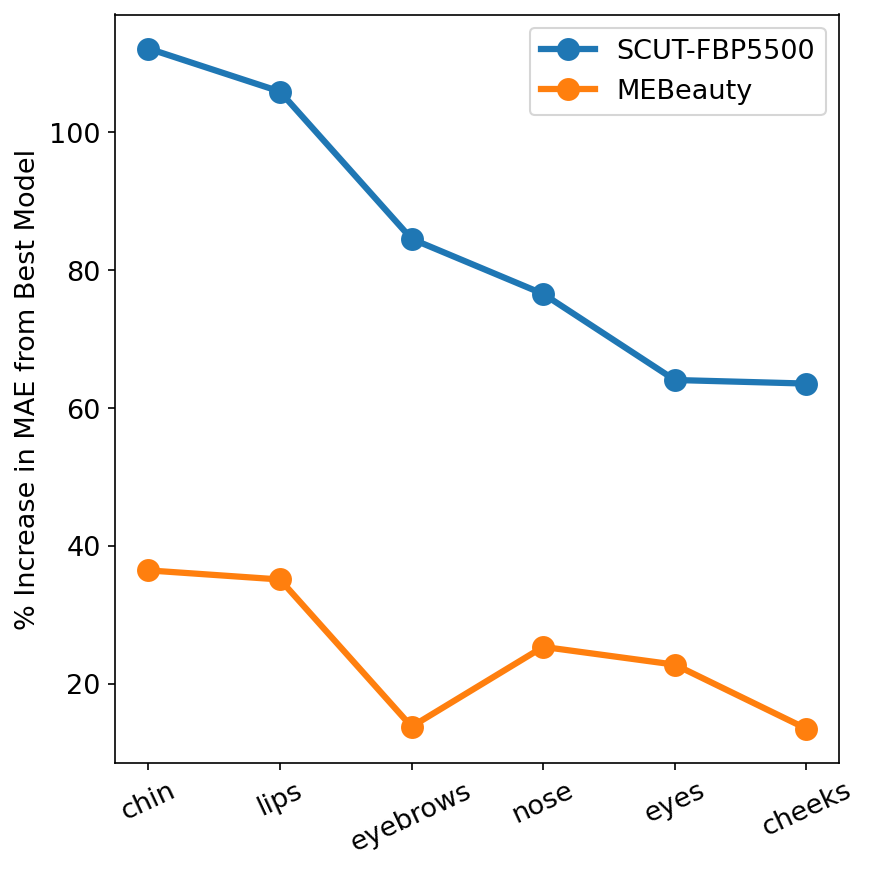

In [35]:
i = 0
plt.figure(figsize=(6, 6), dpi=150)
_, p = SFP("SCUT-FBP5500", combined=True)

for dataset in ["SCUT-FBP5500", "MEBeauty"]:
    scores, _ = SFP(dataset, combined=True)
    plt.plot(
        names4[p][:-1], 
        100*scores[...,i][p][:-1], 
        marker='o', 
        linewidth=3, 
        markersize=10,
        label=dataset
    )

plt.legend(loc="upper right")
plt.ylabel("% Increase in MAE from Best Model")
plt.xticks(rotation=25)
plt.tight_layout()
plt.savefig("SFP_combined_test.png", dpi=300)
plt.show()

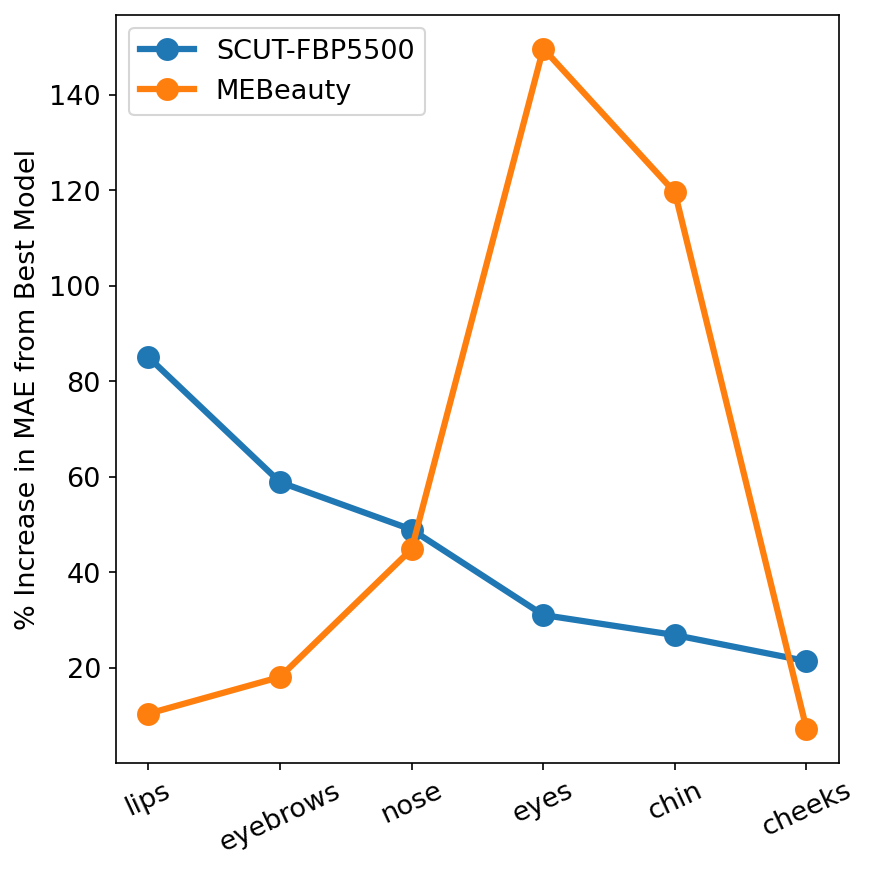

In [36]:
i = 0
plt.figure(figsize=(6, 6), dpi=150)
_, p = SFP("SCUT-FBP5500", combined=True, train=True)

for dataset in ["SCUT-FBP5500", "MEBeauty"]:
    scores, _ = SFP(dataset, combined=True, train=True)
    plt.plot(
        names4[p][:-1], 
        100*scores[...,i][p][:-1], 
        marker='o', 
        linewidth=3, 
        markersize=10,
        label=dataset
    )

plt.legend(loc="upper left")
plt.ylabel("% Increase in MAE from Best Model")
plt.xticks(rotation=25)
plt.tight_layout()
plt.savefig("SFP_combined_train.png", dpi=300)
plt.show()

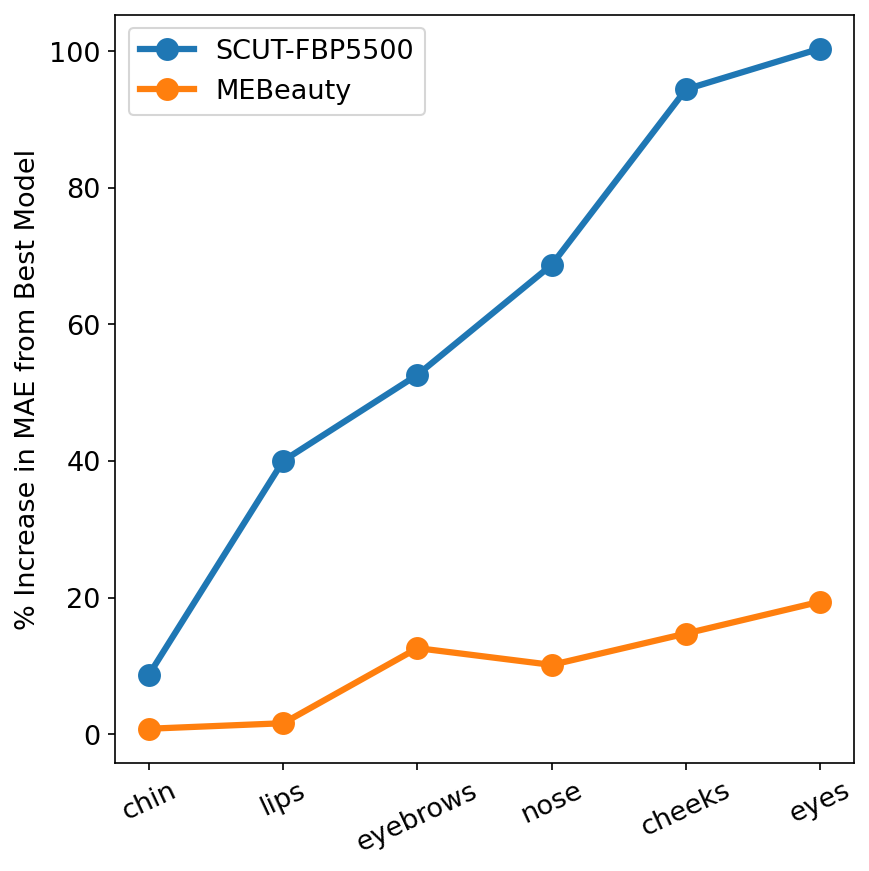

In [37]:
i = 0
plt.figure(figsize=(6, 6), dpi=150)
_, p = PFI("SCUT-FBP5500", combined=True)

for dataset in ["SCUT-FBP5500", "MEBeauty"]:
    scores, _ = PFI(dataset, combined=True)
    plt.plot(
        names4[1:][p], 
        100*scores[...,i][p], 
        marker='o', 
        linewidth=3, 
        markersize=10,
        label=dataset
    )

plt.legend(loc="upper left")
plt.ylabel("% Increase in MAE from Best Model")
plt.xticks(rotation=25)
plt.tight_layout()
plt.savefig("PFI_combined_test.png", dpi=300)
plt.show()

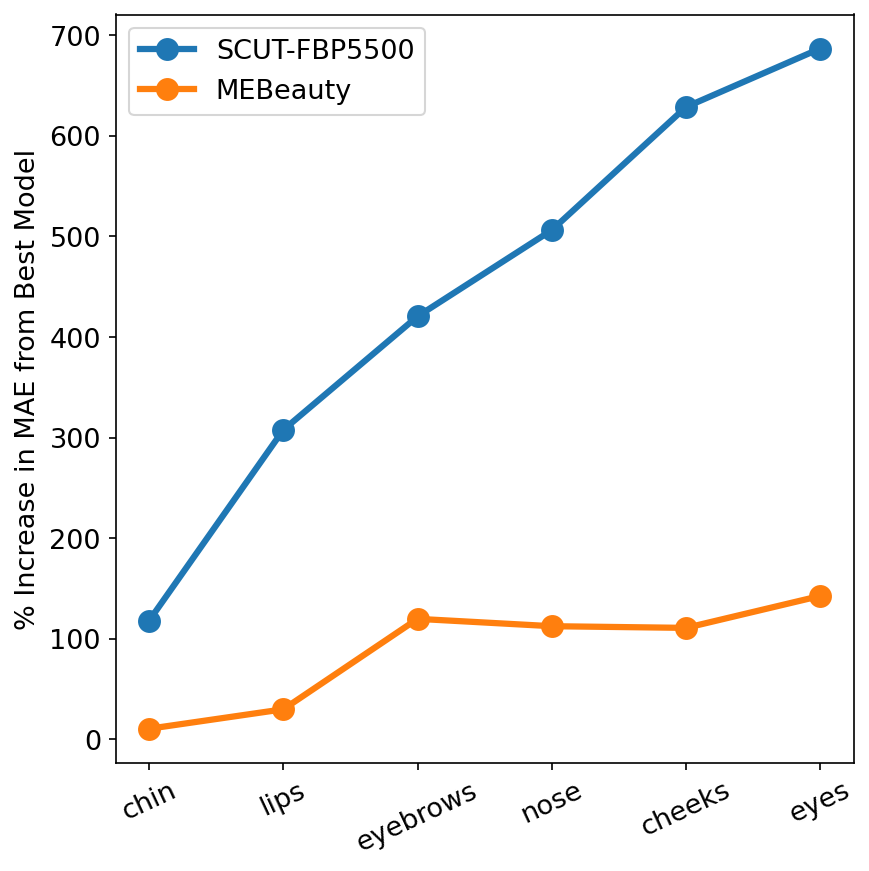

In [40]:
i = 0
plt.figure(figsize=(6, 6), dpi=150)
_, p = PFI("SCUT-FBP5500", combined=True, train=True)

for dataset in ["SCUT-FBP5500", "MEBeauty"]:
    scores, _ = PFI(dataset, combined=True, train=True)
    plt.plot(
        names4[1:][p], 
        100*scores[...,i][p], 
        marker='o', 
        linewidth=3, 
        markersize=10,
        label=dataset
    )

plt.legend(loc="upper left")
plt.ylabel("% Increase in MAE from Best Model")
plt.xticks(rotation=25)
plt.tight_layout()
plt.savefig("PFI_combined_train.png", dpi=300)
plt.show()

In [14]:
y_test = load_y(f"./MEBeauty/test.txt", 10)@np.arange(1,11)
y_pred = np.load(f"./resnet50_vggface/0/categorical_crossentropy/MEBeauty/mediapipe/y_pred.npy")@np.arange(1,11)
print(
    np.sqrt(mean_squared_error(y_test, y_pred)),
    mean_absolute_error(y_test, y_pred),
    pearsonr(y_test, y_pred)[0],
)

0.8488562970784079 0.653304282732787 0.7699919598195795


In [15]:
y_test = load_y(f"./SCUT-FBP5500/test.txt", 5)@np.arange(1,6)
y_pred = np.load(f"./resnet50_vggface/0/categorical_crossentropy/SCUT-FBP5500/mediapipe/y_pred.npy")@np.arange(1,6)
#y_pred = np.load(f"./resnet50_vggface/0/categorical_crossentropy/SCUT-FBP5500/mediapipe2/y_pred.npy")@np.arange(1,6)
#y_pred /= 2
print(
    np.sqrt(mean_squared_error(y_test, y_pred)),
    mean_absolute_error(y_test, y_pred),
    pearsonr(y_test, y_pred)[0],
)

0.24730795725943003 0.18703935723800766 0.9312108870887443


### PFI

In [28]:
scores, p = PFI("MEBeauty", combined=True, percentage=False) 
rounded = np.round(scores,4)
for i in p:
    print(rf"{names4[1:][i]} & {rounded[...,0][i]} & {rounded[...,1][i]} & {rounded[...,2][i]} \\")

print()
scores, p = PFI("MEBeauty", combined=True, percentage=False, train=True) 
rounded = np.round(scores,4)
for i in p:
    print(rf"{names4[1:][i]} & {rounded[...,0][i]} & {rounded[...,1][i]} & {rounded[...,2][i]} \\")

chin & 0.8557 & 0.6659 & 0.7601 \\
lips & 0.8625 & 0.6664 & 0.7537 \\
nose & 0.935 & 0.7284 & 0.7042 \\
eyebrows & 0.9559 & 0.7564 & 0.7025 \\
cheeks & 0.974 & 0.761 & 0.672 \\
eyes & 1.0136 & 0.8007 & 0.6796 \\

chin & 0.3519 & 0.2726 & 0.9665 \\
lips & 0.4135 & 0.3218 & 0.9522 \\
cheeks & 0.6712 & 0.53 & 0.874 \\
nose & 0.6766 & 0.5279 & 0.8724 \\
eyebrows & 0.6998 & 0.5556 & 0.8711 \\
eyes & 0.7723 & 0.6067 & 0.8568 \\


In [29]:
scores, p = PFI("SCUT-FBP5500", combined=True, percentage=False) 
rounded = np.round(scores,4)
for i in p:
    print(rf"{names4[1:][i]} & {rounded[...,0][i]} & {rounded[...,1][i]} & {rounded[...,2][i]} \\")

print()
scores, p = PFI("SCUT-FBP5500", combined=True, percentage=False, train=True) 
rounded = np.round(scores,4)
for i in p:
    print(rf"{names4[1:][i]} & {rounded[...,0][i]} & {rounded[...,1][i]} & {rounded[...,2][i]} \\")

chin & 0.2689 & 0.2052 & 0.9211 \\
lips & 0.3463 & 0.2627 & 0.891 \\
eyebrows & 0.3774 & 0.2839 & 0.8723 \\
nose & 0.4172 & 0.3131 & 0.836 \\
cheeks & 0.4807 & 0.3711 & 0.7964 \\
eyes & 0.4955 & 0.3693 & 0.7678 \\

chin & 0.1232 & 0.0937 & 0.9862 \\
lips & 0.2304 & 0.1734 & 0.9646 \\
eyebrows & 0.2942 & 0.2225 & 0.9389 \\
nose & 0.3427 & 0.2529 & 0.9024 \\
cheeks & 0.4118 & 0.3089 & 0.8721 \\
eyes & 0.4447 & 0.3245 & 0.8338 \\


### SFP

In [30]:
scores, p = SFP("MEBeauty", combined=True, percentage=False) 
rounded = np.round(scores,4)
for i in p:
    print(rf"{names4[i]} & {rounded[...,0][i]} & {rounded[...,1][i]} & {rounded[...,2][i]} \\")

print()
scores, p = SFP("MEBeauty", combined=True, percentage=False, train=True) 
rounded = np.round(scores,4)
for i in p:
    print(rf"{names4[i]} & {rounded[...,0][i]} & {rounded[...,1][i]} & {rounded[...,2][i]} \\")

chin & 1.1584 & 0.9016 & 0.4806 \\
lips & 1.1472 & 0.8933 & 0.5154 \\
nose & 1.0642 & 0.8314 & 0.5831 \\
eyes & 1.0423 & 0.8163 & 0.6166 \\
eyebrows & 0.9659 & 0.7839 & 0.6696 \\
cheeks & 0.9634 & 0.7588 & 0.6815 \\
full face & 0.8489 & 0.6533 & 0.77 \\

eyes & 0.795 & 0.6377 & 0.8599 \\
chin & 0.6991 & 0.5668 & 0.9093 \\
nose & 0.4613 & 0.3626 & 0.9476 \\
eyebrows & 0.376 & 0.2961 & 0.9635 \\
lips & 0.3516 & 0.2747 & 0.9722 \\
cheeks & 0.3415 & 0.2584 & 0.9701 \\
full face & 0.3184 & 0.241 & 0.9733 \\


In [33]:
scores, p = SFP("SCUT-FBP5500", combined=True, percentage=False) 
rounded = np.round(scores,4)
for i in p:
    print(rf"{names4[i]} & {rounded[...,0][i]} & {rounded[...,1][i]} & {rounded[...,2][i]} \\")

print()
scores, p = SFP("SCUT-FBP5500", combined=True, percentage=False, train=True) 
rounded = np.round(scores,4)
for i in p:
    print(rf"{names4[i]} & {rounded[...,0][i]} & {rounded[...,1][i]} & {rounded[...,2][i]} \\")

chin & 0.5247 & 0.3947 & 0.6454 \\
lips & 0.5093 & 0.3897 & 0.6616 \\
eyebrows & 0.4564 & 0.3466 & 0.7405 \\
nose & 0.4367 & 0.3287 & 0.7667 \\
eyes & 0.4058 & 0.3072 & 0.8022 \\
cheeks & 0.4045 & 0.3008 & 0.8054 \\
full face & 0.2473 & 0.187 & 0.9312 \\

lips & 0.1046 & 0.0814 & 0.9925 \\
eyebrows & 0.0898 & 0.0694 & 0.9928 \\
nose & 0.0842 & 0.0645 & 0.9934 \\
eyes & 0.0741 & 0.0569 & 0.9947 \\
chin & 0.0717 & 0.0549 & 0.995 \\
cheeks & 0.0686 & 0.0529 & 0.9958 \\
full face & 0.0565 & 0.0425 & 0.9968 \\
